# 설치 라이브러리 및 설정 #
# 굳이 이대로 안하셔도 되지만 참고용으로 전부 적었습니다.#
CUDA 11.4

cuDNN v8.2.2 (July 6th, 2021), for CUDA 11.4

NVIDIA 그래픽 드라이버 471.11

GPU NVIDIA GeForce GTX 1650 Ti

VisualStudio Build Tools 2019

VisualStudio Community 2019
 
--------

conda 가상환경 python 3.7

pip install tensorflow-gpu==2.6.0

pip install keras

pip install jupyter notebook

pip install ipykernel

pip install pillow

pip install matplotlib


## 이미지 불러와 ndarray로 변경해주는 함수

In [1]:
# 경로 기반으로 재설정한 초기함수
def trash_init(label_filter, resolution):
    base_dir = '이미지_대형폐기물/'
    images = []
    idx = []

    for label in label_filter:
        img_dir = base_dir + label +'/'
        img_list = os.listdir(img_dir)
        print(f'processing {img_dir} folder')

        for img_name in img_list:
            
            imagepath = os.path.join(img_dir, img_name)
            try:
                img = Image.open(imagepath)
            except FileNotFoundError:
                print('FileNotFoundError / continued')
                continue
            except UnidentifiedImageError:
                continue

            img_resized = img.resize(resolution)
            pixels = np.array(img_resized)
            images.append(pixels)


            label_idx = label_filter.index(label)
            idx.append(np.eye(10)[label_idx])

    X = np.asarray(images, dtype=np.float32)
    y = np.asarray(idx)
    
    return X, y

In [2]:
import numpy as np
from PIL import Image
from PIL import UnidentifiedImageError
label_filter = ['침대', '밥상', '서랍장', '수납장', '의자', '선풍기' ,'냉장고', '장롱', '책상', '소파류']
X, y = trash_init(label_filter, [224,224])

processing 이미지_대형폐기물/침대/ folder
processing 이미지_대형폐기물/밥상/ folder
processing 이미지_대형폐기물/서랍장/ folder
processing 이미지_대형폐기물/수납장/ folder
processing 이미지_대형폐기물/의자/ folder
processing 이미지_대형폐기물/선풍기/ folder
processing 이미지_대형폐기물/냉장고/ folder
processing 이미지_대형폐기물/장롱/ folder
processing 이미지_대형폐기물/책상/ folder
processing 이미지_대형폐기물/소파류/ folder


In [3]:
# 종속변수 모양 확인
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

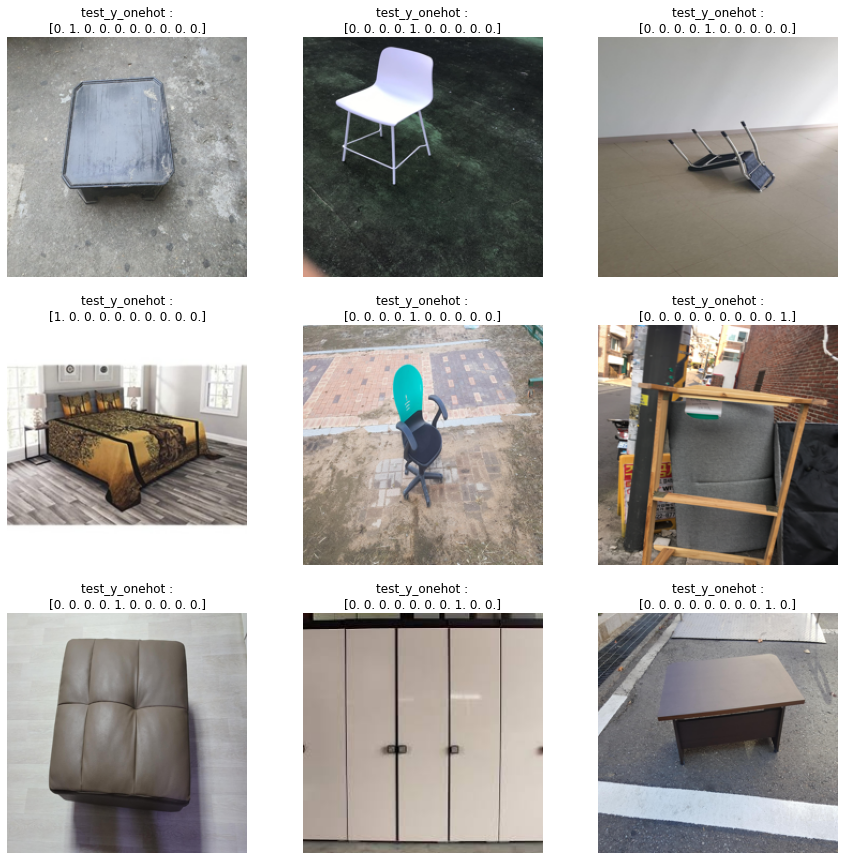

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(3,3, i+1)
    i = np.random.choice(len(y))
    img = X[i]
    
    img_image = Image.fromarray(np.uint8(img))
    
    plt.title('test_y_onehot :\n{}'.format(y[i]))
    plt.axis('off')
    plt.imshow(img_image)

plt.show()

In [5]:
# 정규화
X_norm = X/ 255.0
X_norm.max(), X_norm.min()

(1.0, 0.0)

In [6]:
# 데이터를 섞고 분할
shuffle_map = np.arange(X_norm.shape[0])
np.random.shuffle(shuffle_map)

train_ratio = 0.85
b_idx = int(X_norm.shape[0] * train_ratio)

train_x = X_norm[shuffle_map[:b_idx]] 
train_y = y[shuffle_map[:b_idx]]

test_x  = X_norm[shuffle_map[b_idx:]] 
test_y  = y[shuffle_map[b_idx : ]]

print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)

print("test_x.shape : ", test_x.shape)
print("test_y.shape : ", test_y.shape)

train_x.shape :  (845, 224, 224, 3)
train_y.shape :  (845, 10)
test_x.shape :  (150, 224, 224, 3)
test_y.shape :  (150, 10)


In [7]:
# GPU 사용여부 확인. CPU 정보 아래에 GPU 정보가 떠야 올바르게 적용중입니다.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17875458907497272469
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12913369402067518882
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## 학습 부분

In [8]:
from tensorflow.keras.applications import EfficientNetB0
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [10]:
base_model = EfficientNetB0(input_shape = (224, 224, 3), # 이건 EfficientNet의 기본 설정입니다.
                                include_top = False, # 출력층은 불러오지 않습니다.
                                weights='imagenet')  # 기본 이미지넷 가중치로 시작합니다. 없어도 될듯?

# 이 코드를 실행하면 전이학습입니다.  
#for layer in base_model.layers:    
#    layer.trainable = False


# 출력층입니다.
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# label이 10개이므로 출력유닛도 10개입니다. 다중분류이므로 softmax입니다.
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model_final = tf.keras.Model(inputs= base_model.input, outputs = predictions)

model_final.compile(tf.keras.optimizers.Adam(learning_rate=0.000001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history = model_final.fit(train_x, train_y, 
                            epochs= 50, 
                            batch_size=1,  #임시로 1로 해두었습니다.
                            validation_split=0.2)

# 제 PC에서는 아래와 같은 오류가 뜨고 GPU 메모리 부족 문제라고 합니다.
# CPU를 사용할 때는 정상작동하는 코드입니다.

Epoch 1/50
676/676 [==============================] - 68s 84ms/step - loss: 2.9380 - accuracy: 0.1317 - val_loss: 2.3170 - val_accuracy: 0.1775
Epoch 2/50
676/676 [==============================] - 56s 83ms/step - loss: 2.0497 - accuracy: 0.3402 - val_loss: 2.1724 - val_accuracy: 0.2426
Epoch 3/50
676/676 [==============================] - 57s 84ms/step - loss: 1.6193 - accuracy: 0.4482 - val_loss: 2.1168 - val_accuracy: 0.2426
Epoch 4/50
676/676 [==============================] - 56s 82ms/step - loss: 1.2155 - accuracy: 0.5843 - val_loss: 2.0069 - val_accuracy: 0.2604
Epoch 5/50
676/676 [==============================] - 57s 85ms/step - loss: 0.8881 - accuracy: 0.7219 - val_loss: 1.9853 - val_accuracy: 0.2840
Epoch 6/50
676/676 [==============================] - 58s 86ms/step - loss: 0.7112 - accuracy: 0.7825 - val_loss: 1.9305 - val_accuracy: 0.3254
Epoch 7/50
676/676 [==============================] - 57s 85ms/step - loss: 0.4944 - accuracy: 0.8609 - val_loss: 1.8844 - val_accuracy:

In [9]:
base_model_3 = EfficientNetB0(input_shape = (224, 224, 3), # 이건 EfficientNet의 기본 설정입니다.
                                include_top = False, # 출력층은 불러오지 않습니다.
                                weights='imagenet')  # 기본 이미지넷 가중치로 시작합니다.

# for layer in base_model_3.layers[:16]:    
#     layer.trainable = False

x = base_model_3.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)

# label이 10개이므로 출력유닛도 10개입니다. 다중분류이므로 softmax입니다.
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model_final_3 = tf.keras.Model(inputs= base_model_3.input, outputs = predictions)

model_final_3.compile(tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_3 = model_final_3.fit(train_x, train_y, 
                            epochs= 50, 
                            batch_size=1,  #임시로 1로 해두었습니다.
                            validation_split=0.2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
676/676 [==============================] - 106s 134ms/step - loss: 2.5006 - accuracy: 0.1243 - val_loss: 2.3184 - val_accuracy: 0.1953
Epoch 2/50
676/676 [==============================] - 86s 127ms/step - loss: 2.0009 - accuracy: 0.2441 - val_loss: 2.2195 - val_accuracy: 0.1953
Epoch 3/50
676/676 [==============================] - 85s 126ms/step - loss: 1.7028 - accuracy: 0.3669 - val_loss: 2.2186 - val_accuracy: 0.1716
Epoch 4/50
676/676 [==============================] - 92s 136ms/step - loss: 1.4636 - accuracy: 0.4364 - val_loss: 2.1310 - val_accuracy: 0.3077
Epoch 5/50
676/676 [==============================] - 98s 144ms/step - loss: 1.2720 - accuracy: 0.5192 - val_loss: 2.0334 - val_accuracy: 0.2840
Epoch 6/50
676/676 [==============================] - 91s 135ms/step - loss: 1.0065 - accuracy: 0.6095 - val_loss: 1.9805 - val_accuracy: 0.3314
Epoch 7/50
676/676 [==============================] - 90s 133ms/step - loss: 0.9845 - accuracy: 0.6109 - val_loss: 1.9832 - val_a

In [10]:
base_model_4 = EfficientNetB0(input_shape = (224, 224, 3), # 이건 EfficientNet의 기본 설정입니다.
                                include_top = False, # 출력층은 불러오지 않습니다.
                                weights='imagenet')  # 기본 이미지넷 가중치로 시작합니다.

x = base_model_4.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)

# label이 10개이므로 출력유닛도 10개입니다. 다중분류이므로 softmax입니다.
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model_final_4 = tf.keras.Model(inputs= base_model_4.input, outputs = predictions)

model_final_4.compile(tf.keras.optimizers.RMSprop(learning_rate=0.000005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_3 = model_final_4.fit(train_x, train_y, 
                            epochs= 50, 
                            batch_size=1,  #임시로 1로 해두었습니다.
                            validation_split=0.2,)

Epoch 1/50
676/676 [==============================] - 97s 129ms/step - loss: 2.6194 - accuracy: 0.1257 - val_loss: 2.2847 - val_accuracy: 0.1065
Epoch 2/50
676/676 [==============================] - 86s 127ms/step - loss: 2.1605 - accuracy: 0.2115 - val_loss: 2.2231 - val_accuracy: 0.2012
Epoch 3/50
676/676 [==============================] - 86s 127ms/step - loss: 1.7817 - accuracy: 0.3462 - val_loss: 2.2048 - val_accuracy: 0.2249
Epoch 4/50
676/676 [==============================] - 86s 127ms/step - loss: 1.5841 - accuracy: 0.4231 - val_loss: 2.1468 - val_accuracy: 0.2485
Epoch 5/50
676/676 [==============================] - 90s 133ms/step - loss: 1.4423 - accuracy: 0.4615 - val_loss: 2.1748 - val_accuracy: 0.2426
Epoch 6/50
676/676 [==============================] - 86s 128ms/step - loss: 1.1959 - accuracy: 0.5547 - val_loss: 2.1034 - val_accuracy: 0.2663
Epoch 7/50
676/676 [==============================] - 89s 131ms/step - loss: 1.0789 - accuracy: 0.5917 - val_loss: 2.0802 - val_ac